Links:
- https://github.com/hardmaru/WorldModelsExperiments
- http://blog.otoro.net//2018/06/09/world-models-experiments/


In [ ]:
import torch
import torch.nn as nn

In [4]:
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [5]:
output.shape

torch.Size([5, 3, 20])

In [3]:
%matplotlib inline
import numpy as np
import importlib
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib import animation
import gym
import torch
import torch.nn as nn
from torchvision.transforms import Compose, ToTensor, ToPILImage
from torchsummary import summary
import model.vaelin
VAELin = importlib.reload(vaelin).VAELin
import vae
VAE = importlib.reload(vae).VAE
from dataset import VAEDataset
from torch.utils.data import DataLoader, random_split
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
from PIL import Image
import constants

NameError: name 'vaelin' is not defined

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
# model = VAE(conv_sizes=[4,8,16,32], device=device).to(device)
model = VAELin(z_size=16, device=device).to(device)

summary(model, (3, 64, 64))

In [101]:
dataset = VAEDataset(transform=Compose([
        ToTensor()
    ]))

In [102]:
train_data, test_data = random_split(dataset, [9000, 1000])

In [103]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)
train_iter = len(train_data)//batch_size

In [104]:
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [105]:
num_epochs = 10

In [106]:

for epoch in range(num_epochs):
    with tqdm_notebook(total=train_iter) as bar:
        for batch_idx, train_batch in enumerate(train_loader):
            train_batch = train_batch.to(device)
            optimizer.zero_grad()
            original, decoded, encoded, z, mu, logvar = model.forward(train_batch)
            
            loss, _, _ = model.loss(original, decoded, mu, logvar)
            losses.append(loss.detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            bar.update(1)
            bar.set_postfix(avg_loss=sum(losses[-(batch_idx+1):])/(batch_idx+1))

In [107]:
np_losses = np.array(losses)

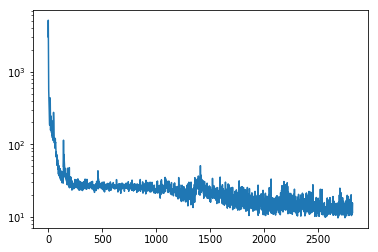

In [108]:
plt.semilogy(np_losses)

In [109]:
model.loss(original, decoded, mu, logvar)

(tensor(11.4803, device='cuda:0', grad_fn=<ThAddBackward>),
 tensor(8.2538, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(3.2265, device='cuda:0', grad_fn=<MeanBackward1>))

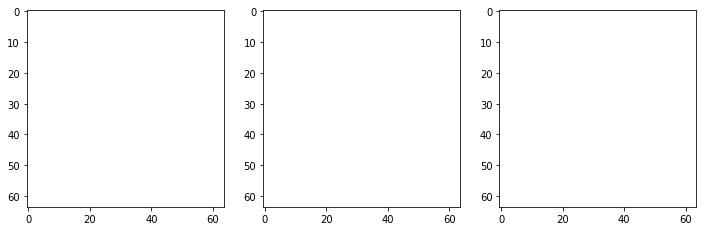

In [113]:
fig = plt.figure(figsize=(12,5))
ims = []
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
for i in range(1000):
    temp = dataset[i].cuda(device).reshape((1, 3, 64, 64))
    inim = temp[0].detach().cpu().numpy().transpose((1,2,0))
    outim = model.forward(temp)[1][0].detach().cpu().numpy().transpose((1,2,0))
    im1 = ax1.imshow(np.abs(inim), animated=True)
    im2 = ax2.imshow(np.abs(outim-inim), animated=True)
    im3 = ax3.imshow(np.abs(outim), animated=True)
    ims.append([im1, im2, im3])
anim = animation.ArtistAnimation(fig, ims, interval=20, blit=True)

In [ ]:
vid = anim.to_html5_video()

In [114]:
HTML(vid)

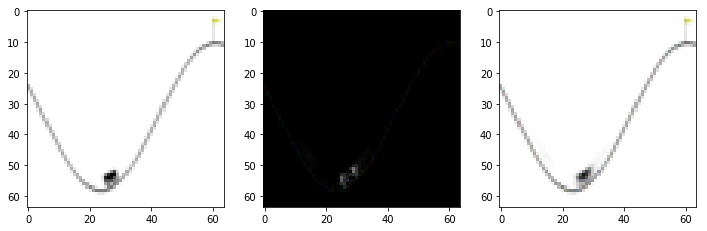

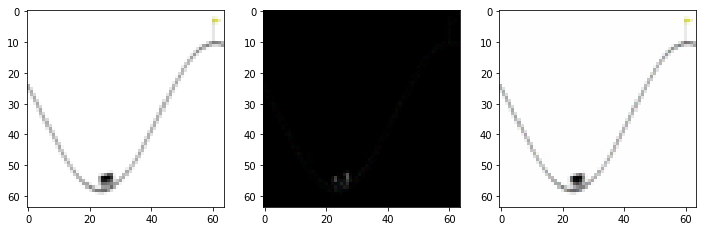

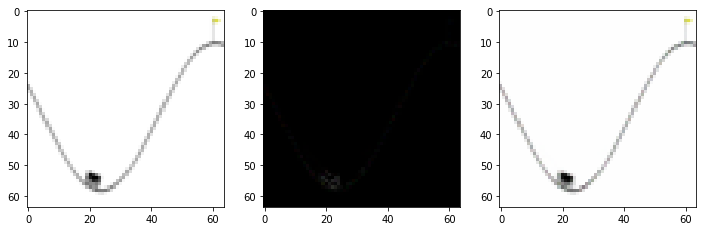

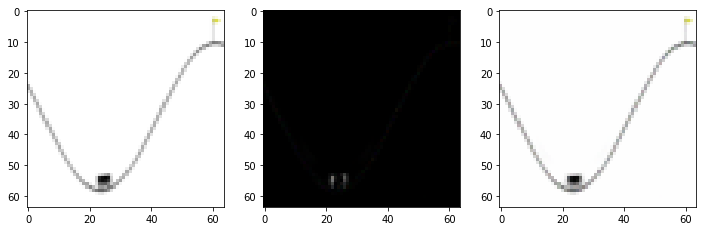

In [115]:

for i in [100, 200, 300, 400]:
    temp = dataset[i].cuda(device).reshape((1, 3, 64, 64))
    inim = temp[0].detach().cpu().numpy().transpose((1,2,0))
    outim = model.forward(temp)[1][0].detach().cpu().numpy().transpose((1,2,0))
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(np.abs(inim))
    plt.subplot(1,3,2)
    plt.imshow(np.abs(outim-inim))
    plt.subplot(1,3,3)
    plt.imshow(np.abs(outim))
    plt.show()
